In [15]:
using Random
using KernelDensity
include("../Inversion/AffineInvariantMCMC.jl")
include("../Inversion/NGFlow.jl")
# include("GMWVI.jl")
include("./MultiModal.jl")
include("../Inversion/Plot.jl")
# include("../Inversion/SVGD.jl")

Gaussian_2d (generic function with 5 methods)

In [16]:
function visualization_comparison_100d(ax, ens_array ; Nx = 200, Ny = 200, x_lim=[-3.0, 3.0], y_lim=[-3.0, 3.0],
    func_F = nothing, func_Phi = nothing, bandwidth=nothing, make_label::Bool=false, N_iter=500)
    
    @assert length(ens_array)==length(ax)-2

    x_min, x_max = x_lim
    y_min, y_max = y_lim
    boundary=((x_lim[1],x_lim[2]),(y_lim[1],y_lim[2]))

    xx = LinRange(x_min, x_max, Nx)
    yy = LinRange(y_min, y_max, Ny)
    dx, dy = xx[2] - xx[1], yy[2] - yy[1]
    X,Y = repeat(xx, 1, Ny), repeat(yy, 1, Nx)'

    Z_ref = (func_Phi === nothing ? posterior_2d(func_F, X, Y, "func_F") : posterior_2d(func_Phi, X, Y, "func_Phi"))
    color_lim = (minimum(Z_ref), maximum(Z_ref))
    ax[1].pcolormesh(X, Y, Z_ref, cmap="viridis", clim=color_lim)

    error = zeros(length(ens_array),N_iter+1)

    last_n_iters = 10  #use the last "last_n_iters" iterations to draw pictures

    for (i,ens) in enumerate(ens_array)
        for iter = 0:N_iter

            if bandwidth==nothing
                kde_iter=kde(ens[:,:,iter+1]'; boundary=boundary, npoints=(Nx,Ny))
            else
                kde_iter=kde(ens[:,:,iter+1]'; boundary=boundary, npoints=(Nx,Ny), bandwidth=bandwidth)
            end

            Z = kde_iter.density/(sum(kde_iter.density)*dx*dy)
            error[i,iter+1] = norm(Z - Z_ref,1)*dx*dy
            
            if iter == N_iter
                
                last_ens = hcat([ens[:,:,i] for i in N_iter+2-last_n_iters:N_iter+1]...)
                last_ens_number =size(last_ens,2)

                if bandwidth==nothing
                    kde_last=kde(last_ens'; boundary=boundary, npoints=(Nx,Ny))
                else
                    kde_last=kde(last_ens'; boundary=boundary, npoints=(Nx,Ny), bandwidth=bandwidth)
                end

                Z = kde_last.density/(sum(kde_last.density)*dx*dy)

                ax[i+1].pcolormesh(X, Y, Z, cmap="viridis", clim=color_lim)
                ax[i+1].scatter(last_ens[1,:], last_ens[2,:], marker=".", color="red", s=10, alpha=min(1,100/last_ens_number))
                ax[i+1].set_xlim(x_lim)
                ax[i+1].set_ylim(y_lim)

            end
        end
    end

    label = ["J="*string(size(ens,2))  for ens in ens_array ]
    ax[5].semilogy(Array(0:N_iter), error', label=label)   
    
    if make_label==true  ax[5].legend()  end

    # Get the current y-axis limits
    ymin, ymax = ax[5].get_ylim()
    # # Ensure the lower bound of y-ticks is below 0.1
    # if ymin > 0.1
    #      ax[5].set_ylim(0.1, ymax)  # Set the lower limit to a value below 0.1
    # end

end

visualization_comparison_100d (generic function with 1 method)

[ Info: ("iter = ", 20, " / ", 200)
[ Info: ("iter = ", 40, " / ", 200)
[ Info: ("iter = ", 60, " / ", 200)
[ Info: ("iter = ", 80, " / ", 200)
[ Info: ("iter = ", 100, " / ", 200)
[ Info: ("iter = ", 120, " / ", 200)
[ Info: ("iter = ", 140, " / ", 200)
[ Info: ("iter = ", 160, " / ", 200)
[ Info: ("iter = ", 180, " / ", 200)
[ Info: ("iter = ", 200, " / ", 200)
[ Info: ("iter = ", 20, " / ", 200)
[ Info: ("iter = ", 40, " / ", 200)
[ Info: ("iter = ", 60, " / ", 200)
[ Info: ("iter = ", 80, " / ", 200)
[ Info: ("iter = ", 100, " / ", 200)
[ Info: ("iter = ", 120, " / ", 200)
[ Info: ("iter = ", 140, " / ", 200)
[ Info: ("iter = ", 160, " / ", 200)
[ Info: ("iter = ", 180, " / ", 200)
[ Info: ("iter = ", 200, " / ", 200)
[ Info: ("iter = ", 20, " / ", 200)
[ Info: ("iter = ", 40, " / ", 200)
[ Info: ("iter = ", 60, " / ", 200)
[ Info: ("iter = ", 80, " / ", 200)
[ Info: ("iter = ", 100, " / ", 200)
[ Info: ("iter = ", 120, " / ", 200)
[ Info: ("iter = ", 140, " / ", 200)
[ Info: ("ite

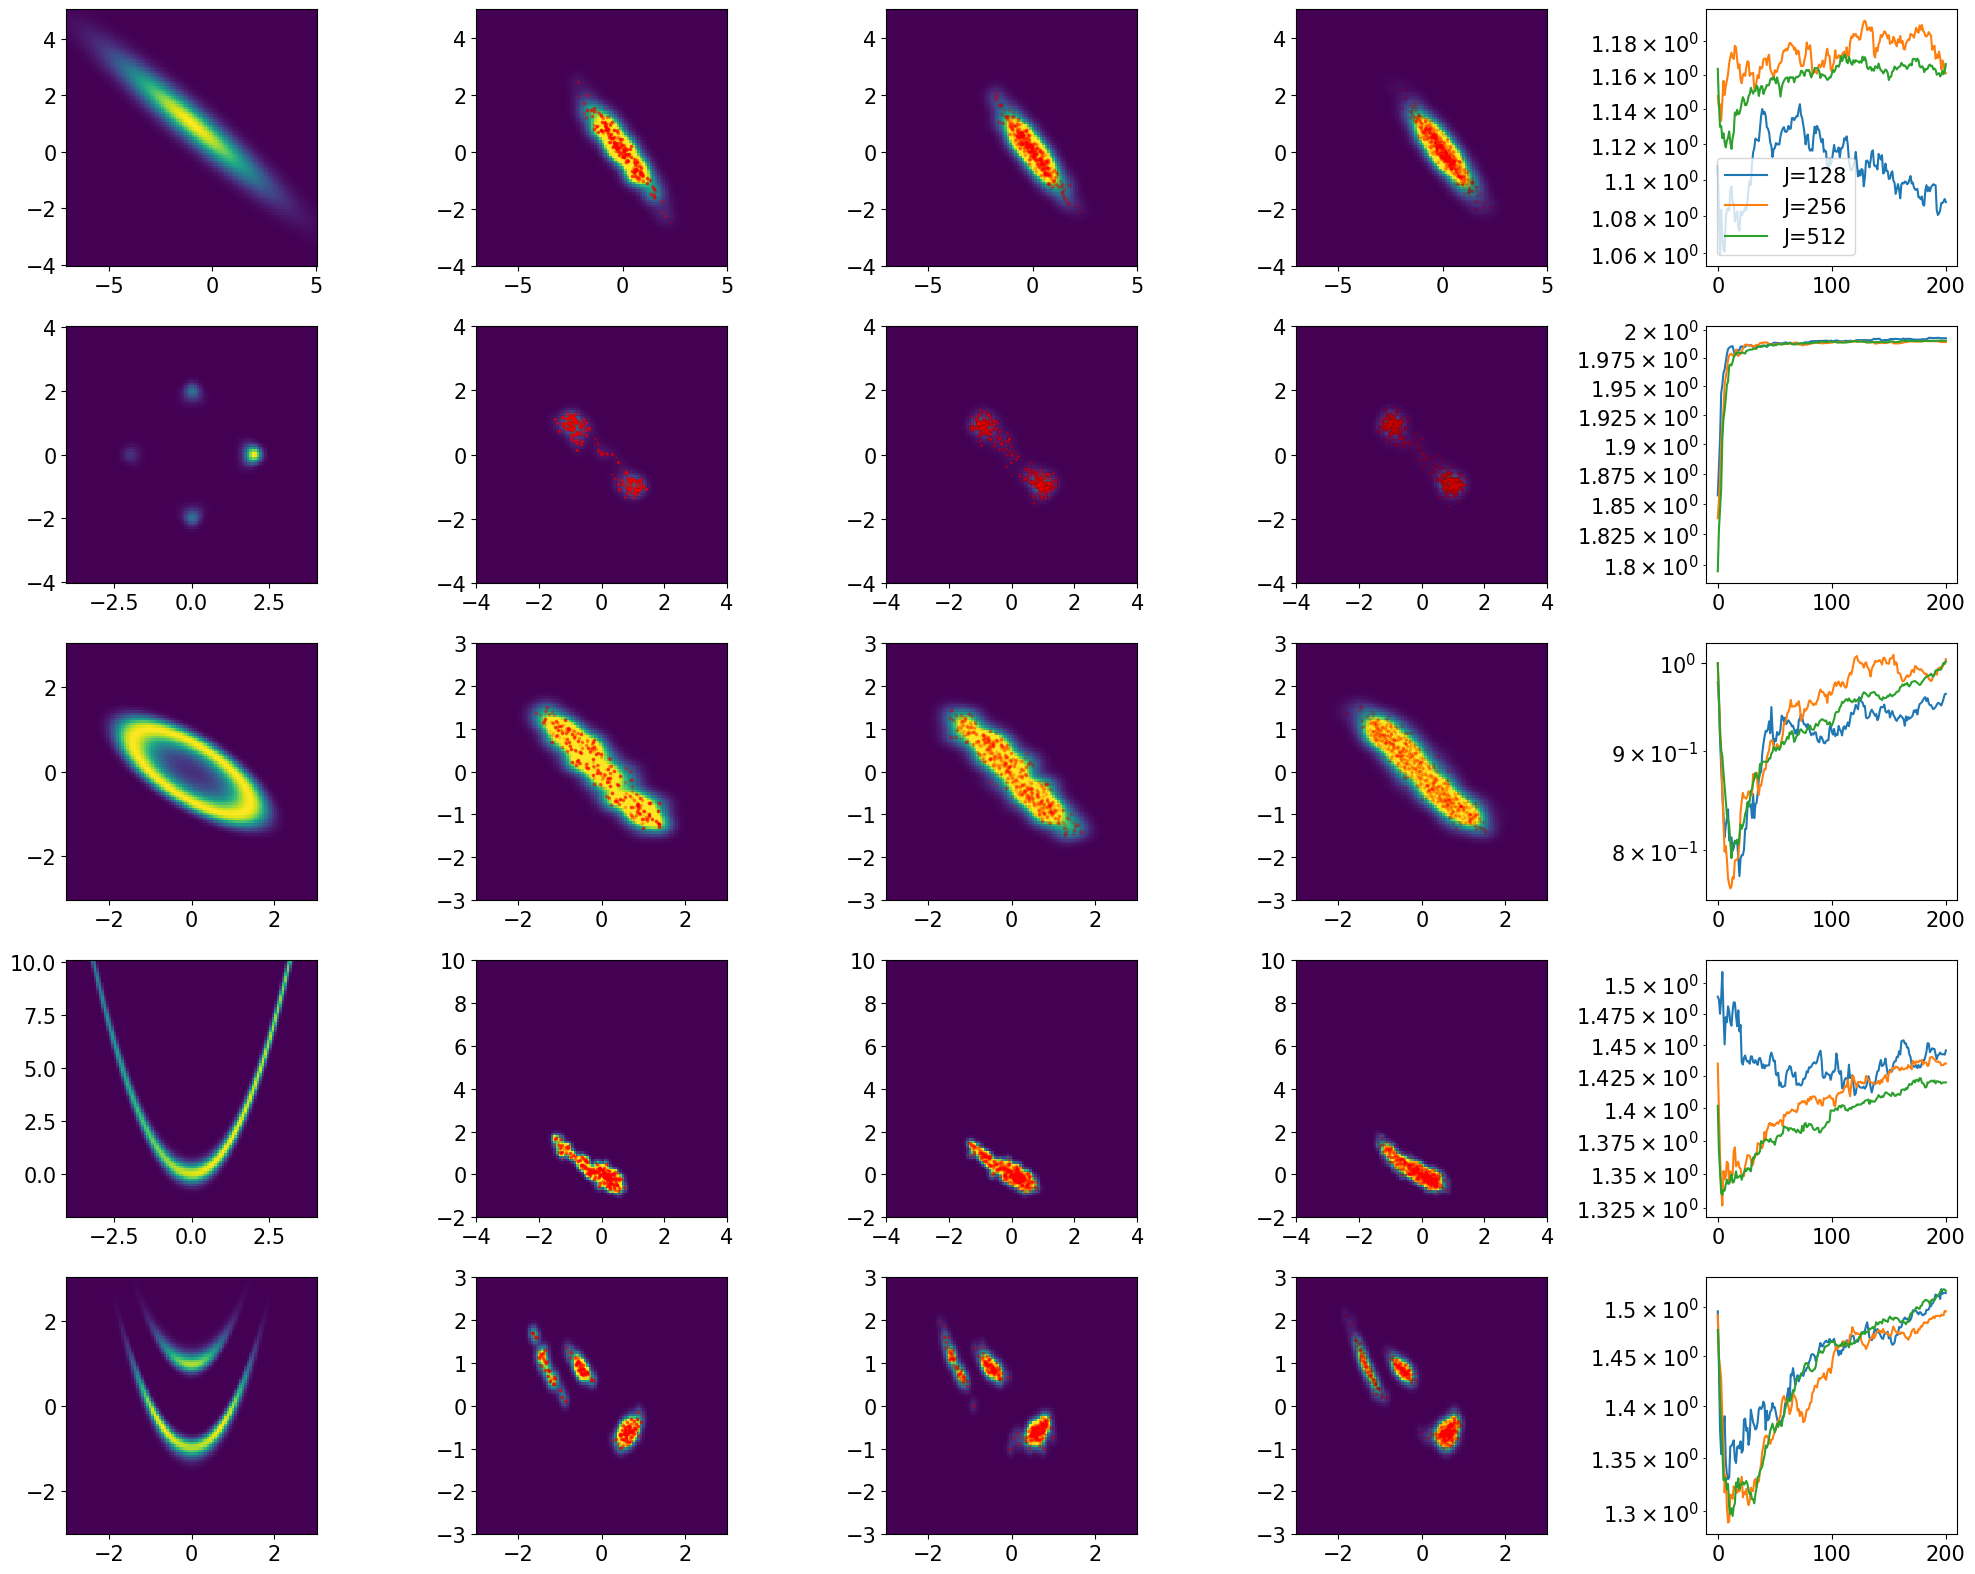

In [19]:
fig, ax = PyPlot.subplots(nrows=5, ncols=5, sharex=false, sharey=false, figsize=(20,16))

Random.seed!(111);

N_x = 100
N_ens_array = [128,256,512]
μ0, Σ0 = zeros(N_x), 1*Diagonal(ones(N_x))

N_ens_max = N_ens_array[end]
ens_0 = zeros(N_x,N_ens_max)

for j = 1:N_ens_max
    ens_0[:,j]  = rand(MvNormal(zeros(N_x), Σ0)) + μ0
end 

N_iter = 200
Nx, Ny = 100,100


ση = 1.0
Gtype = "Gaussian"
A = [1.0 1.0; 1.0 2.0]
y = [0.0; 1.0; zeros(N_x-2)]
func_args = (y, ση, A , Gtype)
func_F(x) = F(x, func_args)
func_dPhi(x) = dPhi(x, func_args)
log_prob(x) = logrho(x, func_args)
func_prob(x)=exp(log_prob(x))
ens_MCMC = [ Run_StretchMove(ens_0[:,1:N_ens], func_prob; output="History", N_iter=N_iter)[1:2,:,:]  for N_ens in N_ens_array ]
y_2d = y[1:2]
func_args = (y_2d, ση, A , Gtype)
func_F(x) = F(x, func_args)
visualization_comparison_100d(ax[1,:], ens_MCMC ; Nx = Nx, Ny = Ny, x_lim=[-7.0, 5.0], y_lim=[-4.0, 5.0], func_F=func_F, 
    bandwidth=(0.32,0.22), make_label=true,  N_iter= N_iter)



ση = 1.0
Gtype = "Four_modes"
y = [4.2297; 4.2297; 0.5; 0.0; zeros(N_x-2)]
func_args = (y, ση, 0, Gtype)
func_F(x) = F(x, func_args)
func_dPhi(x) = dPhi(x, func_args)
func_prob(x)=exp(logrho(x, func_args))
ens_MCMC = [ Run_StretchMove(ens_0[:,1:N_ens], func_prob; output="History", N_iter=N_iter)[1:2,:,:]  for N_ens in N_ens_array ]
y_2d = y[1:4]
func_args = (y_2d, ση, A , Gtype)
func_F(x) = F(x, func_args)
visualization_comparison_100d(ax[2,:], ens_MCMC ; Nx = Nx, Ny = Ny, x_lim=[-4.0, 4.0], y_lim=[-4, 4], func_F=func_F, 
    bandwidth=(0.14,0.14), make_label=false,  N_iter= N_iter)



ση = [0.5; ones(N_x-2)]
Gtype = "Circle"
A = [1.0 1.0; 1.0 2.0]
y = [1.0; zeros(N_x-2)]
func_args = (y, ση, A , Gtype)
func_F(x) = F(x, func_args)
func_dPhi(x) = dPhi(x, func_args)
func_prob(x)=exp(logrho(x, func_args))
ens_MCMC = [ Run_StretchMove(ens_0[:,1:N_ens], func_prob; output="History", N_iter=N_iter)[1:2,:,:]  for N_ens in N_ens_array ]
y_2d, ση_2d = y[1:1], ση[1:1]
func_args = (y_2d, ση_2d, A , Gtype)
func_F(x) = F(x, func_args)
visualization_comparison_100d(ax[3,:], ens_MCMC; Nx = Nx, Ny = Ny, x_lim=[-3.0, 3.0], y_lim=[-3.0, 3.0], func_F=func_F, 
    bandwidth=(0.20,0.14), make_label=false,  N_iter= N_iter)



ση = [sqrt(10.0); sqrt(10.0); ones(N_x-2)]
Gtype = "Banana"
λ = 10.0
y = [0.0; 1.0; zeros(N_x-2)]
func_args = (y, ση, λ , Gtype)
func_F(x) = F(x, func_args)
func_dPhi(x) = dPhi(x, func_args)
func_prob(x)=exp(logrho(x, func_args))
ens_MCMC = [ Run_StretchMove(ens_0[:,1:N_ens], func_prob; output="History", N_iter=N_iter)[1:2,:,:]  for N_ens in N_ens_array ]
y_2d, ση_2d = y[1:2], ση[1:2]
func_args = (y_2d, ση_2d, λ , Gtype)
func_F(x) = F(x, func_args)
visualization_comparison_100d(ax[4,:], ens_MCMC ; Nx = Nx, Ny = Ny, x_lim=[-4.0, 4.0], y_lim=[-2.0, 10.0], func_F=func_F, 
    bandwidth=(0.06,0.11), make_label=false,  N_iter= N_iter)



ση = [0.3; 1.0; 1.0; ones(N_x-2)]
Gtype = "Double_banana"
λ = 100.0
y = [log(λ+1); 0.0; 0.0; zeros(N_x-2)]
func_args = (y, ση, λ , Gtype)
func_F(x) = F(x, func_args)
func_dPhi(x) = dPhi(x, func_args)
func_prob(x)=exp(logrho(x, func_args))
ens_MCMC = [ Run_StretchMove(ens_0[:,1:N_ens], func_prob; output="History", N_iter=N_iter)[1:2,:,:]  for N_ens in N_ens_array ]
y_2d, ση_2d = y[1:3], ση[1:3]
func_args = (y_2d, ση_2d, λ , Gtype)
func_F(x) = F(x, func_args)
visualization_comparison_100d(ax[5,:], ens_MCMC; Nx = Nx, Ny = Ny, x_lim=[-3.0, 3.0], y_lim=[-3.0, 3.0], func_F=func_F, 
    bandwidth=(0.06,0.11), make_label=false,  N_iter= N_iter)


    
fig.tight_layout()
fig.savefig("MultiModal-Comparison-100D.pdf")